# Лабораторная работа 2.
# Решение краевых задач. Методы коллокации, наименьших квадратов и Галеркина (sympy version).

In [22]:
import sympy as sp
import numpy as np
from IPython.display import display
import math 
import pylab
import scipy

sp.init_printing(use_latex='mathjax')

def get_basis_function(n):
    if not n:
        return lambda x: 0
    return lambda x: x ** (n - 1)  * (1 - x ** 2) 

def get_basis_system(num_of_basis_functions):
    return [get_basis_function(n) for n in range(num_of_basis_functions)]

def get_list_of_unknown_coefficients(num):
    return [sp.Symbol('a' + str(n)) for n in range(1, num + 1)]

def get_approximate_solution(basis_system):
    x = sp.Symbol('x')
    unknown_coefficients = get_list_of_unknown_coefficients(len(basis_system) - 1)
    approximate_solution = basis_system[0](x) + \
                           sum([unknown_coefficients[n] * basis_system[n + 1](x)\
                           for n in range(len(basis_system) - 1)]) 
    return approximate_solution

def get_residual(approximate_solution, p, q, f):
    x = sp.Symbol('x')
    residual = (sp.diff(approximate_solution, x, 2) + \
                p * sp.diff(approximate_solution, x) + \
                q * approximate_solution - f)
    return residual

def normalize_coefficients(coefficients, f):
    p = coefficients[1] / coefficients[0]
    q = coefficients[2] / coefficients[0]
    f /= coefficients[0]
    return p, q, f

def show_plots(functions, start_x, end_x, dx):
    for function in functions:
        dx = 0.01
        xlist = np.arange(start_x, end_x, dx)
        ylist = [function(p) for p in xlist]
        pylab.plot (xlist, ylist)
    pylab.grid(True)
    pylab.show()

### Ищем приближенное решение краевой задачи в виде 
$
y_n(x) = \phi_0(x) + \sum_{i=0}^N \phi_i(x) * a_i
$
, где 
$\phi_i$ - базисная система, $a_i$ - неизвестные коэффициенты

### Рассматриваем невязку
$\psi(x_1, a_1, ..., a_n) = p(x) * y_n''(x) + q(x) * y_n'(x) + r(x) * y_n(x) - f(x)$



### Все способы решения задачи сводятся к решению СЛАУ относительно коэффициентов $a_i$

# Метод коллокации

$$
\begin{cases} \psi(x_1, a_1, ..., a_n) = 0, \\ ... \\ \psi(x_n, a_1, ..., a_n) = 0.\end{cases}
$$

In [23]:
import time

def solve_boundary_task_with_collocation_method(coefficients, f,
                                                collocation_points,
                                                num_of_basis_functions):
    p, q, f = normalize_coefficients(coefficients, f)
    x = sp.Symbol('x')
    basis_system = get_basis_system(num_of_basis_functions)
    unknown_coefficients = get_list_of_unknown_coefficients(len(collocation_points))
    approximate_solution = get_approximate_solution(basis_system)
    residual = get_residual(approximate_solution, p, q, f)
    system_of_equations = [residual.subs({x:point}) for point in collocation_points]
    found_coefficients = sp.solve(system_of_equations, unknown_coefficients)
    answer = approximate_solution.subs(found_coefficients)
    return answer

# Метод наименьших квадратов
# Интегральный МНК

$$
I = \int_a^b \psi^2(x, a_1, ..., a_n)dx
$$

$$
\begin{cases} \frac{\partial I}{\partial a_1} = 0,\\ ... \\ \frac{\partial I}{\partial a_n} = 0. \end{cases}
$$

In [24]:
def solve_boundary_task_with_integral_LSM(coefficients, f, num_of_basis_functions, a, b):
    p, q, f = normalize_coefficients(coefficients, f)
    x = sp.Symbol('x')
    basis_system = get_basis_system(num_of_basis_functions)
    unknown_coefficients = get_list_of_unknown_coefficients(num_of_basis_functions - 1)
    approximate_solution = get_approximate_solution(basis_system)
    residual = get_residual(approximate_solution, p, q, f)
    I = sp.integrate(residual ** 2, (x, a, b))
    system_of_equations = [(sp.diff(I, c)) for c in unknown_coefficients]
    found_coefficients = sp.solve(system_of_equations, unknown_coefficients)
    answer = approximate_solution.subs(found_coefficients)
    return answer

# Дискретный МНК

$$
S = \sum_{i=0}^N \psi^2(x_i, a_1, ..., a_n)
$$

$$
\begin{cases} \frac{\partial S}{\partial a_1} = 0,\\ ... \\ \frac{\partial S}{\partial a_n} = 0. \end{cases}
$$

In [25]:
def solve_boundary_task_with_discrete_LSM(coefficients, f, num_of_basis_functions, points):
    p, q, f = normalize_coefficients(coefficients, f)
    x = sp.Symbol('x')
    basis_system = get_basis_system(num_of_basis_functions)
    unknown_coefficients = get_list_of_unknown_coefficients(num_of_basis_functions - 1)
    approximate_solution = get_approximate_solution(basis_system)
    residual = get_residual(approximate_solution, p, q, f)
    S = sum([(residual ** 2).subs({x:point}) for point in points])
    system_of_equations = [sp.diff(S, c) for c in unknown_coefficients]
    found_coefficients = sp.solve(system_of_equations, unknown_coefficients)
    answer = approximate_solution.subs(found_coefficients)
    return answer

# Метод Галеркина

$$
\begin{cases} \int_a^b \psi(x, a_1, ..., a_n)\phi_1(x)x = 0, \\ ... \\
\int_a^b \psi(x, a_1, ..., a_n)\phi_n(x)dx = 0.\end{cases}
$$

In [26]:
def solve_boundary_task_with_Galerkin_method(coefficients, f, num_of_basis_functions, a, b):
    p, q, f = normalize_coefficients(coefficients, f)
    x = sp.Symbol('x')
    basis_system = get_basis_system(num_of_basis_functions)
    unknown_coefficients = get_list_of_unknown_coefficients(num_of_basis_functions - 1)
    approximate_solution = get_approximate_solution(basis_system)
    residual = get_residual(approximate_solution, p, q, f)
    system_of_equations = [sp.integrate(residual * fi(x), (x, a, b)) for fi in basis_system[1:]]
    found_coefficients = sp.solve(system_of_equations, unknown_coefficients)
    answer = approximate_solution.subs(found_coefficients)
    return answer

$$ 1) y'' + (1 + x^2) * y = -1;
\\ -1 <= x <= 1; 
\\ y(-1) = y(1) = 0; $$

2.4536328315734863


                        9 ⎛   2    ⎞                         8 ⎛   2    ⎞     
- 2.18983358502014e-17⋅x ⋅⎝- x  + 1⎠ + 0.000317517538151249⋅x ⋅⎝- x  + 1⎠ + 3.

                    7 ⎛   2    ⎞                         6 ⎛   2    ⎞         
57145177407635e-17⋅x ⋅⎝- x  + 1⎠ + 0.000978645987125208⋅x ⋅⎝- x  + 1⎠ - 9.9372

                5 ⎛   2    ⎞                      4 ⎛   2    ⎞                
7377395273e-18⋅x ⋅⎝- x  + 1⎠ - 0.031145335799505⋅x ⋅⎝- x  + 1⎠ - 8.64032620423

         3 ⎛   2    ⎞                       2 ⎛   2    ⎞                      
519e-19⋅x ⋅⎝- x  + 1⎠ - 0.0339731082117818⋅x ⋅⎝- x  + 1⎠ - 0.932053367273255⋅x

2                          ⎛   2    ⎞                    
  - 1.43038170039333e-18⋅x⋅⎝- x  + 1⎠ + 0.932053367273255

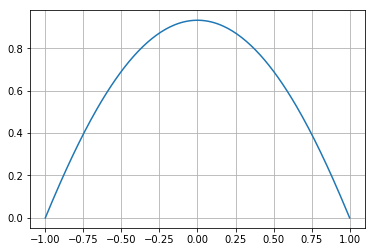

In [38]:
import time 

x = sp.Symbol('x')
first_equation_coefficients = [1, 0, 1 + x ** 2]
a = -1
b = 1
dx = 0.01

collocation_points = list(np.linspace(-1, 1, num=10))
num_of_basis_functions = len(collocation_points) + 1

answer_1_with_collocation_method = solve_boundary_task_with_collocation_method(
                                   first_equation_coefficients, -1,
                                   collocation_points,
                                   num_of_basis_functions)
display(answer_1_with_collocation_method)
show_plots([sp.lambdify(x, answer_1_with_collocation_method)], a, b + dx, dx)

                      8 ⎛   2    ⎞                         6 ⎛   2    ⎞       
0.000310615405164556⋅x ⋅⎝- x  + 1⎠ + 0.000992238851113851⋅x ⋅⎝- x  + 1⎠ - 0.03

                4 ⎛   2    ⎞                      2 ⎛   2    ⎞                
11520251674971⋅x ⋅⎝- x  + 1⎠ - 0.033971919312074⋅x ⋅⎝- x  + 1⎠ - 0.93205369497

      2                    
4462⋅x  + 0.932053694974462

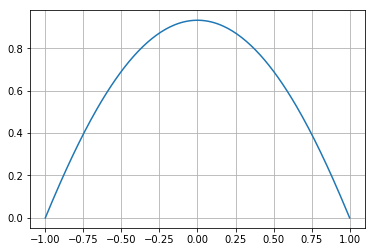

In [39]:
answer_1_with_integral_LSM = solve_boundary_task_with_integral_LSM(first_equation_coefficients,                                                                   
                                                                   -1, num_of_basis_functions,
                                                                   -1, 1)
display(answer_1_with_integral_LSM)
show_plots([sp.lambdify(x, answer_1_with_integral_LSM)], a, b + dx, dx)

                      9 ⎛   2    ⎞                         8 ⎛   2    ⎞       
9.24379859497582e-15⋅x ⋅⎝- x  + 1⎠ + 0.000308850787326299⋅x ⋅⎝- x  + 1⎠ - 2.27

                  7 ⎛   2    ⎞                         6 ⎛   2    ⎞           
441567966779e-14⋅x ⋅⎝- x  + 1⎠ + 0.000995086266476458⋅x ⋅⎝- x  + 1⎠ + 1.856064

              5 ⎛   2    ⎞                       4 ⎛   2    ⎞                 
25536977e-14⋅x ⋅⎝- x  + 1⎠ - 0.0311534235478774⋅x ⋅⎝- x  + 1⎠ - 5.568773033796

        3 ⎛   2    ⎞                       2 ⎛   2    ⎞                      2
85e-15⋅x ⋅⎝- x  + 1⎠ - 0.0339717086487463⋅x ⋅⎝- x  + 1⎠ - 0.932053689104513⋅x 

                          ⎛   2    ⎞                    
 + 4.09845622430188e-16⋅x⋅⎝- x  + 1⎠ + 0.932053689104513

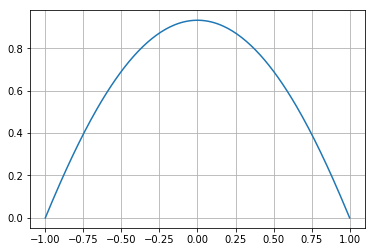

In [40]:
points = list(np.linspace(-1, 1, num=30))
answer_1_with_discrete_LSM = solve_boundary_task_with_discrete_LSM(
                             first_equation_coefficients,                                                                   
                             -1, num_of_basis_functions,
                             points)
display(answer_1_with_discrete_LSM)
show_plots([sp.lambdify(x, answer_1_with_discrete_LSM)], a, b + dx, dx)

                      8 ⎛   2    ⎞                         6 ⎛   2    ⎞       
0.000315382615562463⋅x ⋅⎝- x  + 1⎠ + 0.000984379596071305⋅x ⋅⎝- x  + 1⎠ - 0.03

                4 ⎛   2    ⎞                       2 ⎛   2    ⎞               
11480922719873⋅x ⋅⎝- x  + 1⎠ - 0.0339725245763525⋅x ⋅⎝- x  + 1⎠ - 0.9320537087

       2                    
26196⋅x  + 0.932053708726196

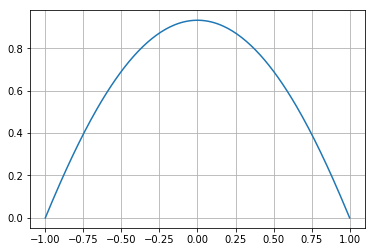

In [41]:
answer_1_with_Galerkin_method = solve_boundary_task_with_Galerkin_method(first_equation_coefficients,                                                                   
                                                                   -1, num_of_basis_functions,
                                                                   -1, 1)
display(answer_1_with_Galerkin_method)
show_plots([sp.lambdify(x, answer_1_with_Galerkin_method)], a, b + dx, dx)

In [42]:
first_answer = list(map(lambda method: sp.lambdify(x, method), 
                        [answer_1_with_collocation_method,
                         answer_1_with_integral_LSM,
                         answer_1_with_discrete_LSM,
                         answer_1_with_Galerkin_method]))

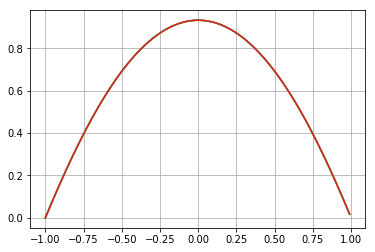

In [43]:
show_plots(first_answer, -1, 1, 0.001)

$$ 2) sin(1) * y'' + (1 + cos(1) * x^2) * y = -1;
\\-1 <= x <= 1;
\\ y(-1) = y(1) = 0; $$

                      9 ⎛   2    ⎞                         8 ⎛   2    ⎞       
1.42146032348003e-16⋅x ⋅⎝- x  + 1⎠ + 0.000141542000423018⋅x ⋅⎝- x  + 1⎠ - 2.77

                 7 ⎛   2    ⎞                        6 ⎛   2    ⎞             
76407848545e-16⋅x ⋅⎝- x  + 1⎠ + 0.00147106609997315⋅x ⋅⎝- x  + 1⎠ + 1.44253386

            5 ⎛   2    ⎞                       4 ⎛   2    ⎞                   
210996e-16⋅x ⋅⎝- x  + 1⎠ - 0.0244690025908247⋅x ⋅⎝- x  + 1⎠ - 1.3374170879058e

     3 ⎛   2    ⎞                       2 ⎛   2    ⎞                     2    
-17⋅x ⋅⎝- x  + 1⎠ - 0.0899439428997418⋅x ⋅⎝- x  + 1⎠ - 1.24260821739835⋅x  - 9

                      ⎛   2    ⎞                   
.16049649928324e-18⋅x⋅⎝- x  + 1⎠ + 1.24260821739835

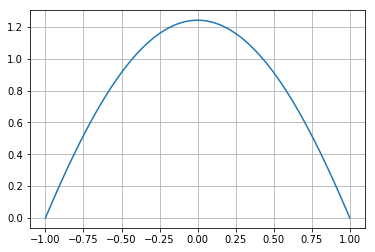

In [44]:
second_equation_coefficients = [math.sin(1), 0, 1 + math.cos(1) * x ** 2]
collocation_points = list(np.linspace(-1, 1, num=10))
num_of_basis_functions = len(collocation_points) + 1

answer_2_with_collocation_method = solve_boundary_task_with_collocation_method(
                                   second_equation_coefficients, -1,
                                   collocation_points, num_of_basis_functions)
display(answer_2_with_collocation_method)
show_plots([sp.lambdify(x, answer_2_with_collocation_method)], a, b + dx, dx)

                      8 ⎛   2    ⎞                        6 ⎛   2    ⎞        
0.000136799113124716⋅x ⋅⎝- x  + 1⎠ + 0.00148040034500203⋅x ⋅⎝- x  + 1⎠ - 0.024

               4 ⎛   2    ⎞                      2 ⎛   2    ⎞                 
4736020141123⋅x ⋅⎝- x  + 1⎠ - 0.089943138121499⋅x ⋅⎝- x  + 1⎠ - 1.242608466665

   2                  
4⋅x  + 1.2426084666654

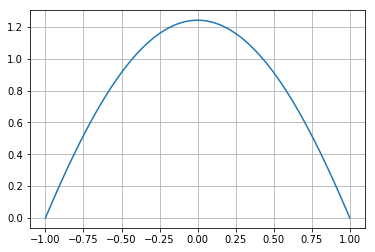

In [45]:
answer_2_with_integral_LSM = solve_boundary_task_with_integral_LSM(
                             second_equation_coefficients, -1,
                             num_of_basis_functions, -1, 1)
display(answer_2_with_integral_LSM)
show_plots([sp.lambdify(x, answer_2_with_integral_LSM)], a, b + dx, dx)

                      9 ⎛   2    ⎞                        8 ⎛   2    ⎞        
1.73220742455969e-15⋅x ⋅⎝- x  + 1⎠ + 0.00013563111838496⋅x ⋅⎝- x  + 1⎠ - 4.334

                 7 ⎛   2    ⎞                        6 ⎛   2    ⎞             
25579051097e-15⋅x ⋅⎝- x  + 1⎠ + 0.00148228706442884⋅x ⋅⎝- x  + 1⎠ + 3.68548637

            5 ⎛   2    ⎞                       4 ⎛   2    ⎞                   
073643e-15⋅x ⋅⎝- x  + 1⎠ - 0.0244745296429755⋅x ⋅⎝- x  + 1⎠ - 1.22695386837005

      3 ⎛   2    ⎞                       2 ⎛   2    ⎞                     2   
e-15⋅x ⋅⎝- x  + 1⎠ - 0.0899429980882508⋅x ⋅⎝- x  + 1⎠ - 1.24260846273065⋅x  + 

                       ⎛   2    ⎞                   
1.13467499949265e-16⋅x⋅⎝- x  + 1⎠ + 1.24260846273065

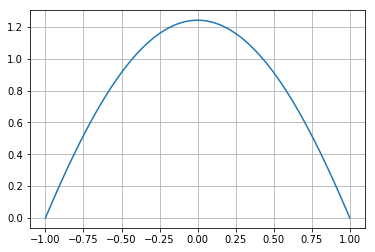

In [46]:
answer_2_with_discrete_LSM = solve_boundary_task_with_discrete_LSM(
                             second_equation_coefficients, -1,
                             num_of_basis_functions, points)
display(answer_2_with_discrete_LSM)
show_plots([sp.lambdify(x, answer_2_with_discrete_LSM)], a, b + dx, dx)

                      8 ⎛   2    ⎞                        6 ⎛   2    ⎞        
0.000140036127994996⋅x ⋅⎝- x  + 1⎠ + 0.00147506166577869⋅x ⋅⎝- x  + 1⎠ - 0.024

               4 ⎛   2    ⎞                       2 ⎛   2    ⎞                
4709286813582⋅x ⋅⎝- x  + 1⎠ - 0.0899435500321944⋅x ⋅⎝- x  + 1⎠ - 1.24260847604

    2                  
11⋅x  + 1.2426084760411

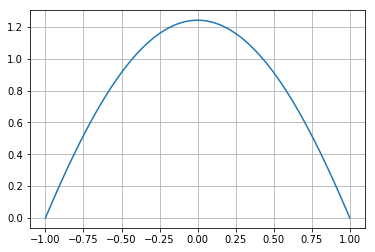

In [47]:
answer_2_with_Galerkin_method = solve_boundary_task_with_Galerkin_method(
                                second_equation_coefficients, -1,
                                num_of_basis_functions, -1, 1)
display(answer_2_with_Galerkin_method)
show_plots([sp.lambdify(x, answer_2_with_Galerkin_method)], a, b + dx, dx)

In [48]:
second_answer = list(map(lambda method: sp.lambdify(x, method), 
                        [answer_2_with_collocation_method,
                         answer_2_with_integral_LSM,
                         answer_2_with_discrete_LSM,
                         answer_2_with_Galerkin_method]))

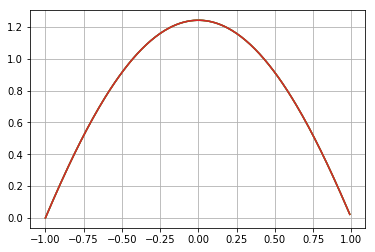

In [49]:
show_plots(second_answer, -1, 1, 0.01)